In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [3]:
df = pd.read_csv('load_readings.csv')

# Exploration and Cleaning

In [4]:
df.head()

,Timestamp,Voltage,Current
0,1.710077e+09,-0.074002,-0.038876
1,1.710077e+09,-0.074877,-0.011250
2,1.710077e+09,-0.074377,-0.035876
3,1.710077e+09,-0.074627,-0.029501
4,1.710077e+09,-0.075127,-0.019376


In [5]:
df.replace({'None':np.nan}, inplace=True)

In [6]:
df.shape

(1475, 3)

In [7]:
df.isna().sum()

Timestamp    0
 Voltage     0
 Current     0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isna().sum().sum()

0

In [10]:
df.columns = df.columns.str.strip()

In [11]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

In [12]:
df.head()

,Timestamp,Voltage,Current
0,2024-03-10 13:22:11.140960000,-0.074002,-0.038876
1,2024-03-10 13:22:16.170296064,-0.074877,-0.011250
2,2024-03-10 13:22:21.201404160,-0.074377,-0.035876
3,2024-03-10 13:22:26.232348928,-0.074627,-0.029501
4,2024-03-10 13:22:31.263334912,-0.075127,-0.019376


In [13]:
df.describe()

,Voltage,Current
count,1475.000000,1475.000000
mean,-0.261907,-0.274821
std,0.108489,0.123813
min,-0.529891,-0.484765
25%,-0.342010,-0.375761
50%,-0.259008,-0.287509
75%,-0.173943,-0.178255
max,-0.072627,-0.010250


# Visualization

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [17]:
df['Voltage'] = abs(df['Voltage'])
df['Current'] = abs(df['Current'])
df.head()

,Timestamp,Voltage,Current
0,2024-03-10 13:22:11.140960000,0.074002,0.038876
1,2024-03-10 13:22:16.170296064,0.074877,0.011250
2,2024-03-10 13:22:21.201404160,0.074377,0.035876
3,2024-03-10 13:22:26.232348928,0.074627,0.029501
4,2024-03-10 13:22:31.263334912,0.075127,0.019376


In [18]:
# Voltage sensor calibration (0 to 25 volt)
X = np.array([0.07, 3.126595416119877]).reshape(-1, 1)
y = np.array([0, 25])
lr_voltage = LinearRegression()
lr_voltage.fit(X, y)
df['Voltage'] = lr_voltage.predict(df[['Voltage']])

# Current sensor calibration (0.06 mA = 0.8887771233252968)
X = np.array([0.8887771233252968, 0.9406537064729759, 0.9624043702505569, 1.0315314798425246]).reshape(-1, 1)
y = np.array([0.06, 0.32, 0.64, 0.95])
lr_current = LinearRegression()
lr_current.fit(X, y)
df['Current'] = lr_current.predict(df[['Current']])

In [19]:
df['Voltage'] = abs(df['Voltage'])
df['Current'] = abs(df['Current'])
df.head(100)

,Timestamp,Voltage,Current
0,2024-03-10 13:22:11.140960000,0.032735,5.377758
1,2024-03-10 13:22:16.170296064,0.039891,5.554614
2,2024-03-10 13:22:21.201404160,0.035802,5.396964
3,2024-03-10 13:22:26.232348928,0.037847,5.437777
4,2024-03-10 13:22:31.263334912,0.041936,5.502597
...,...,...,...
95,2024-03-10 13:30:09.176587008,1.542835,3.750043
96,2024-03-10 13:30:14.208589056,1.556126,3.950906
97,2024-03-10 13:30:19.240067840,1.558171,3.822066
98,2024-03-10 13:30:24.273883136,1.555104,3.804460


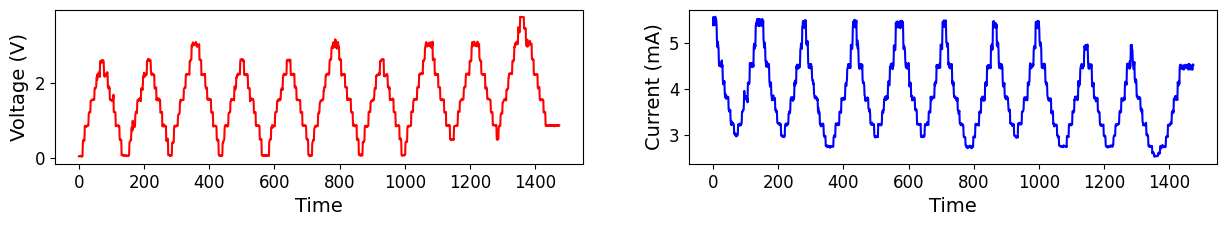

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,2))
sns.lineplot(x=df.index, y=df['Voltage'], color='red', ax=axes[0]);
sns.lineplot(x=df.index, y=df['Current'], color='blue', ax=axes[1]);
axes[0].set_ylabel('Voltage (V)', fontsize=14)
axes[0].set_xlabel('Time', fontsize=14)
axes[1].set_ylabel('Current (mA)', fontsize=14)
axes[1].set_xlabel('Time', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12);

In [82]:
df['Load Power'] = df['Voltage'] * df['Current'] * .001 # Amperes

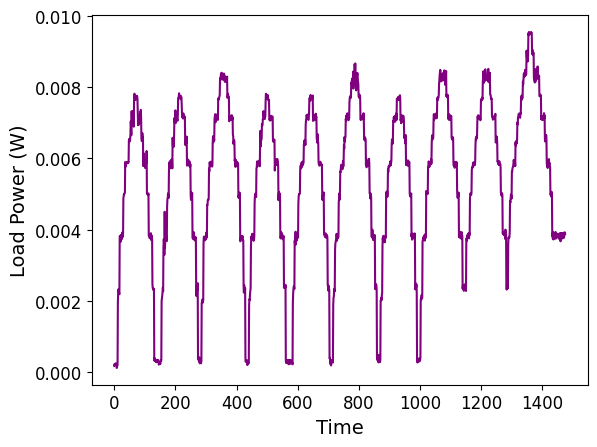

In [23]:
sns.lineplot(x=df.index, y=df['Load Power'], color='purple');
plt.xlabel('Time', fontsize=14)
plt.ylabel('Load Power (W)', fontsize=14)
plt.xticks(fontsize=12)             
plt.yticks(fontsize=12);             

# Prediction data

In [83]:
import h5py

series = df['Load Power']*10
arr3 = (np.array(series)[4:140:2]/2)[4:64]
print(arr3.shape)
with h5py.File('load_array.h5', 'w') as hf:
        hf.create_dataset('load_array', data=arr3)

(60,)


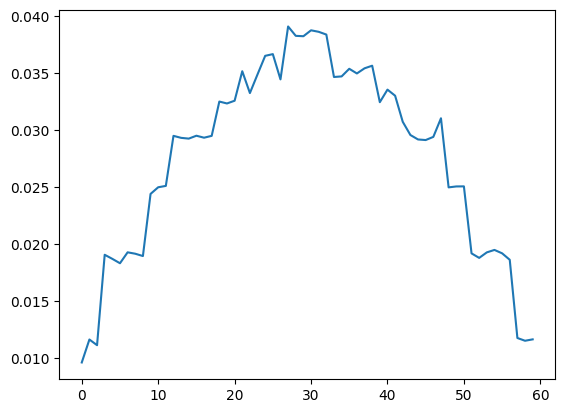

In [84]:
plt.plot(arr3);

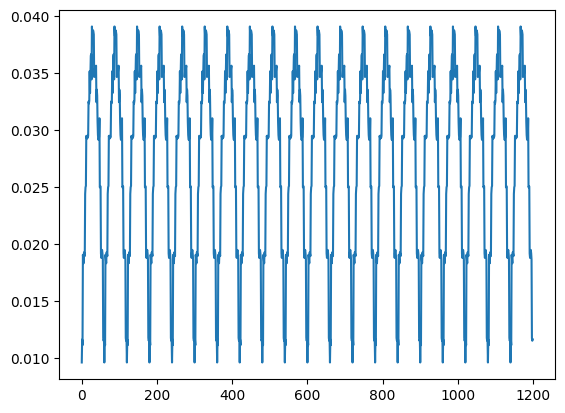

In [91]:
import matplotlib.pyplot as plt
import h5py

with h5py.File('load_array.h5', 'r') as hf:
    arr = np.array(hf['load_array'])

arr_repeated = np.tile(arr, 20)

plt.plot(arr_repeated);

In [96]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
flattened_scaled = scaler.fit_transform(arr_repeated.reshape(-1, 1)).flatten()

X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened_scaled, 60)
X_train.shape

(912, 60, 1)

In [137]:
model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(70, return_sequences=True),
    Dropout(0.2),
    LSTM(70, return_sequences=True),
    Dropout(0.2),
    LSTM(70, return_sequences=True),
    Dropout(0.2),
    LSTM(70),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate = .0001), loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val,y_val))

Epoch 1/100
57/57 [==============================] - 18s 171ms/step - loss: 0.2099 - val_loss: 0.1163
Epoch 2/100
57/57 [==============================] - 7s 113ms/step - loss: 0.0963 - val_loss: 0.0745
Epoch 3/100
57/57 [==============================] - 6s 112ms/step - loss: 0.0412 - val_loss: 0.0132
Epoch 4/100
57/57 [==============================] - 6s 109ms/step - loss: 0.0181 - val_loss: 0.0107
Epoch 5/100
57/57 [==============================] - 6s 107ms/step - loss: 0.0175 - val_loss: 0.0079
Epoch 6/100
57/57 [==============================] - 6s 112ms/step - loss: 0.0154 - val_loss: 0.0088
Epoch 7/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0142 - val_loss: 0.0079
Epoch 8/100
57/57 [==============================] - 6s 104ms/step - loss: 0.0133 - val_loss: 0.0084
Epoch 9/100
57/57 [==============================] - 6s 100ms/step - loss: 0.0121 - val_loss: 0.0057
Epoch 10/100
57/57 [==============================] - 6s 103ms/step - loss: 0.0117 - val_l

KeyboardInterrupt: 

In [174]:
model.save('lstm_load.keras')

In [142]:
import pickle
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

4/4 [==============================] - 0s 53ms/step - loss: 0.0033
0.0033225237857550383
4/4 [==============================] - 0s 52ms/step


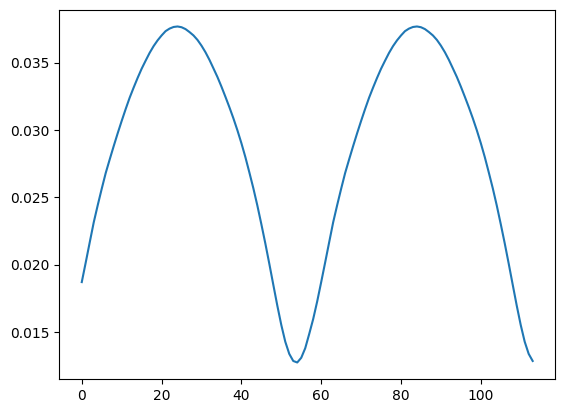

In [252]:
print(model.evaluate(X_test, y_test))
y_pred = model.predict(X_test)
y_pred_og = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
plt.plot(y_pred_og)

In [170]:
np.save('X_test.npy', X_test)
X_test = np.load('X_test.npy')

In [248]:
records = X_test.shape[0]
i = i+1 if i<records else 0
estimate = abs(model.predict(X_test[i].reshape(1,60,1))[0][0])
estimated_demand = scaler.inverse_transform(estimate.reshape(-1, 1))
print(estimated_demand)

1/1 [==============================] - 0s 46ms/step
[[0.03314734]]


In [ ]:
# put and load X_test, model, minmax_scaler, and change load  endpoint code 
# i = 0 init 
# each time endpoint called, i+=1 till records

# Training

In [93]:
def flattened_to_matrix(flat, window_size):
  X, y = [], []
  for i in range(len(flat) - window_size):
    row = [[x] for x in flat[i : i+window_size]]
    X.append(row)
    y.append(flat[i+window_size])
  return X,y

In [94]:
def windowing(arr, window_size):
  X, y = flattened_to_matrix(arr, window_size)
  X, y = np.array(X), np.array(y)

  a = X.shape[0]
  X_train, y_train = X[:int(0.8*a)], y[:int(0.8*a)]
  X_val, y_val = X[int(0.8*a):int(0.9*a)], y[int(0.8*a):int(0.9*a)]
  X_test, y_test = X[int(0.9*a):], y[int(0.9*a):]
  return X_train, y_train, X_val, y_val, X_test, y_test

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
X = df.drop(columns=['Timestamp', 'Current', 'Voltage'])
flattened = pd.Series(X.values.flatten(), dtype=np.float64)

In [31]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened, 60)
X_train.shape[1]

60

In [52]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened, 60)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate = .001), loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val,y_val))

Epoch 1/100
145/145 [==============================] - 8s 32ms/step - loss: 3.8304e-06 - val_loss: 1.1519e-06
Epoch 2/100
145/145 [==============================] - 4s 28ms/step - loss: 5.4519e-07 - val_loss: 2.5750e-07
Epoch 3/100
145/145 [==============================] - 4s 27ms/step - loss: 5.5970e-07 - val_loss: 2.4768e-07
Epoch 4/100
145/145 [==============================] - 4s 28ms/step - loss: 4.9850e-07 - val_loss: 1.2078e-07
Epoch 5/100
145/145 [==============================] - 4s 28ms/step - loss: 3.6162e-07 - val_loss: 1.1407e-07
Epoch 6/100
145/145 [==============================] - 4s 28ms/step - loss: 2.7738e-07 - val_loss: 1.2152e-07
Epoch 7/100
145/145 [==============================] - 4s 28ms/step - loss: 3.2115e-07 - val_loss: 1.6897e-07
Epoch 8/100
145/145 [==============================] - 4s 29ms/step - loss: 4.1984e-07 - val_loss: 6.3891e-07
Epoch 9/100
145/145 [==============================] - 5s 33ms/step - loss: 2.6978e-07 - val_loss: 1.9945e-07
Epoch 10/1

In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
flattened_scaled = scaler.fit_transform(flattened.values.reshape(-1, 1)).flatten()

X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened_scaled, 60)

In [53]:
from keras.models import load_model
model = load_model('best_load_readings.keras')
model.compile(optimizer=Adam(learning_rate = .0001), loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val,y_val))

Epoch 1/10
71/71 [==============================] - 4s 30ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 2/10
71/71 [==============================] - 2s 26ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 3/10
71/71 [==============================] - 2s 25ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 4/10
71/71 [==============================] - 2s 25ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 5/10
71/71 [==============================] - 2s 26ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 6/10
71/71 [==============================] - 2s 30ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 7/10
71/71 [==============================] - 2s 28ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 8/10
71/71 [==============================] - 2s 25ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 9/10
71/71 [==============================] - 2s 28ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 10/10
71/71 [==============================] - 2s 29ms/step - loss: 0.0027 - val_loss: 0.0012


# Predictions

In [56]:
from keras.models import load_model
model = load_model('best_load_readings.keras')
y_pred = model.predict(X_test)
print(model.evaluate(X_test, y_test))
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

5/5 [==============================] - 0s 15ms/step - loss: 0.0014
0.0013535921461880207


In [68]:
y_pred_plot = y_pred_original
y_test_plot = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

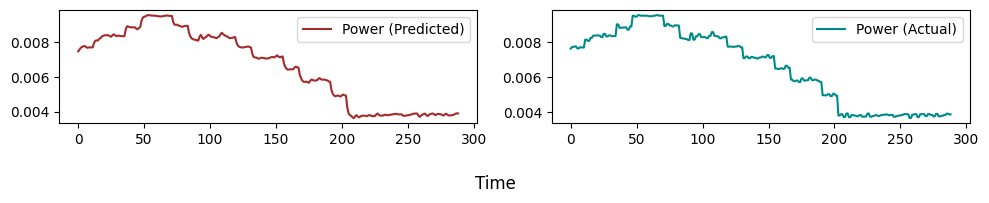

In [70]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,2))
sns.lineplot(y_pred_plot, color='brown', ax=axes[0], label='Power (Predicted)');
sns.lineplot(y_test_plot, color='darkcyan', ax=axes[1], label='Power (Actual)');

fig.supxlabel('Time')
plt.tight_layout();

In [74]:
def predict_windowing(flat, window_size=60):
    X = []
    row = [[x] for x in flat[0 : 0+window_size]]
    X.append(row)
    return np.array(X)

model.predict(predict_windowing(X_test[-1].flatten()))

1/1 [==============================] - 0s 57ms/step


array([[0.4018858]], dtype=float32)